## The CBOW Architecture

### Build the corpus vocabulary

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [2]:
corpus = ['The sky is blue and beautiful,',
         'Love this blue and beautiful sky!',
         'The quick brown fox jumps over the lazy dog.',
         "A king's breakfast has sausages, ham, bacon, eggs, toast, and beans",
         'I love green eggs, ham, sausages and bacon!',
         'The brown fox is quick anf the blue dog is lazy!',
         'The sky is very blue and the sky is very beautiful today',
         'The dog is lazy but the brown fox is quick!']
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document' : corpus,
                         'Category' : labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,"The sky is blue and beautiful,",weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast, and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick anf the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


In [3]:
wpt = nltk.WordPunctTokenizer()

In [4]:
stop_words = nltk.corpus.stopwords.words('english')

In [5]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

In [6]:
normalize_corpus = np.vectorize(normalize_document)

In [7]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick anf blue dog lazy',
       'sky blue sky beautiful today', 'dog lazy brown fox quick'],
      dtype='<U51')

In [8]:
from nltk.corpus import gutenberg
from string import punctuation

In [9]:
bible = gutenberg.sents('bible-kjv.txt')

In [10]:
remove_terms = punctuation + '0123456789'

In [11]:
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


## Implementing the Continuous Bag of Words (CBOW) model

### Build the corpus vocabulary

In [12]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

Using TensorFlow backend.


In [13]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

In [14]:
# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v : k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


### Build a CBOW (contex, target) generator

In [15]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size * 2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i]
                                for i in range(start, end)
                                if 0 <= i < sentence_length
                                 and i != index])
            label_word.append(word)
            
            x = sequence.pad_sequences(context_words, maxlen = context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield(x, y)

In [16]:
# Test this out for some examples

i = 0
for x, y in generate_context_word_pairs(corpus = wids, window_size = window_size, vocab_size = vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


In [17]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

In [18]:
# bulld CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim = vocab_size, output_dim = embed_size, input_length = window_size * 2))
cbow.add(Lambda(lambda x: K.mean(x, axis = 1), output_shape = (embed_size,)))
cbow.add(Dense(vocab_size, activation = 'softmax'))
cbow.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


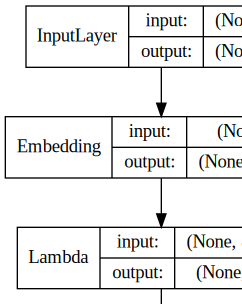

In [19]:
# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes = True, show_layer_names = False,
                rankdir = 'TB').create(prog = 'dot', format = 'svg'))

### Train the model

In [20]:
for epoch in range(1, 4):
    loss = 0.0
    i = 0
    for x, y in generate_context_word_pairs(corpus = wids, window_size = window_size, vocab_size = vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))
            
print('Epoch:', epoch, '\tLoss:', loss)
print()

C:\Users\dalan\anaconda3\envs\Packages\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 3 	Loss: 5643893.039533119



In [21]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index = list(id2word.values())[1:]).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
unto,2.724105,2.542851,2.103535,2.018700,2.612822,2.160132,2.423507,2.218793,2.406465,2.013501,...,-2.201379,2.364313,2.419034,-2.521388,-2.359560,-2.002176,2.389988,-2.484634,2.284837,2.769314
lord,1.916376,1.746418,2.353972,1.661239,2.130417,2.087705,2.139691,1.969467,1.973661,2.139762,...,-2.200145,2.562431,2.245866,-2.099961,-2.402019,-2.091239,1.965681,-2.014546,2.152701,1.937042
thou,1.463074,1.288384,1.621969,1.382023,2.030033,2.365587,1.711562,2.331369,1.797766,1.544043,...,-1.341234,2.204820,1.595766,-2.285288,-1.546738,-1.767799,1.104856,-1.518950,2.080063,1.744810
thy,2.176781,1.980541,1.784633,1.367590,1.690474,2.251390,1.911056,1.996371,2.150168,1.908925,...,-1.738845,2.082861,1.729089,-2.008243,-1.738870,-1.667373,1.703266,-1.710272,1.768384,2.092158
god,1.666263,1.813679,1.708619,1.277712,2.231061,2.161661,1.883334,2.236696,1.647958,1.934193,...,-1.641103,1.733814,1.474875,-1.884667,-1.483192,-1.740509,1.602463,-1.778034,1.996362,2.188818


In [22]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

#view contextuality similar words
similar_words = {search_term : [id2word[idx] for idx in distance_matrix[word2id[search_term] - 1].argsort()[1 : 6] + 1]
                for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses', 'famine']}

similar_words

(12424, 12424)


{'god': ['also', 'man', 'ye', 'lord', 'hath'],
 'jesus': ['spirit', 'evil', 'gave', 'hands', 'heard'],
 'noah': ['journeyed', 'burdens', 'floor', 'perished', 'filthy'],
 'egypt': ['tree', 'babylon', 'mount', 'trees', 'though'],
 'john': ['peter', 'entered', 'disciples', 'passed', 'received'],
 'gospel': ['grace', 'hope', 'gentiles', 'hearts', 'saints'],
 'moses': ['kept', 'wise', 'departed', 'throughout', 'sun'],
 'famine': ['reproach', 'fallen', 'deep', 'slay', 'sleep']}

## The Skip Gram model

### Build the corpus vocabulary

In [23]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v : k for k, v in word2id.items()}

vocab_size = len(word2id) + 1
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [24]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size = vocab_size, window_size = 10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
    id2word[pairs[i][0]], pairs[i][0],
    id2word[pairs[i][1]], pairs[i][1],
    labels[i]))

(james (1154), badness (8603)) -> 0
(king (13), bible (5766)) -> 1
(bible (5766), king (13)) -> 1
(king (13), jeremy (8122)) -> 0
(king (13), abdeel (11001)) -> 0
(james (1154), bible (5766)) -> 1
(bible (5766), james (1154)) -> 1
(james (1154), zachariah (5452)) -> 0
(bible (5766), entappuah (9093)) -> 0
(james (1154), king (13)) -> 1


### Build the skip-gram model architecture

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_2_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1242500     embedding_2_input[0][0]          
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       1242500     embedding_3_input[0][0]          
____________________________________________________________________________________________

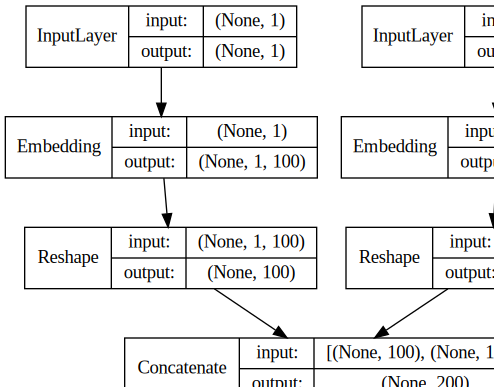

In [25]:
from keras.layers import Concatenate
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras import Model

# build skip-gram architecture
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                        embeddings_initializer = 'glorot_uniform',
                        input_length = 1))
word_model.add(Reshape((embed_size,)))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                           embeddings_initializer = 'glorot_uniform',
                           input_length = 1))
context_model.add(Reshape((embed_size,)))

model = Concatenate(axis = 1)([word_model.output, context_model.output])
model = Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid')(model)

model = Model([word_model.input, context_model.input], model)

model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop')

# view model summary
print(model.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes = True, show_layer_names = False,
                rankdir = 'TB').create(prog = 'dot', format = 'svg'))

### Train the model

In [26]:
for epoch in range(1, 4):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype = 'int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype = 'int32')
        labels = np.array(elem[1], dtype = 'int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X, Y)
        
    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs


C:\Users\dalan\anaconda3\envs\Packages\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 3675.256048529409
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3205.4641918134876
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 3121.5985806973185
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs


KeyboardInterrupt: 

### Get the embeddings

In [ ]:
merge_layer = model.layers[0]
word_model = merge_layer.layers[0]
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index = id2word.values()).head()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term : [id2word[idx] for idx in distance_matrix[word2id[search_term] - 1].argsort()[1 : 6] + 1]
                for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses', 'famine']}

similar_words

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array(weights[idx] for idx in words_ids)
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components = 2, random_state = 0, n_iter = 10000, perplexity = 3)
np.set_printoptions(supress = True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize = (14, 8))
plt.scatter(T[:, 0], T[:, 1], c = 'steelblue', esgecolors = 'k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy = (x + 1, y + 1), xytext = (0, 0), textcoords = 'offset points')